# `rpy2`

We can run `R` code in our `python` jupyter notebook by using the `rmagic` commands, which are part of the [`rpy2` package](https://rpy2.readthedocs.io/en/version_2.8.x/index.html). 

First we import the `ipython` module from rpy2

In [1]:
%load_ext rpy2.ipython

We can execute a line of R code using the `%R` prefix. The last returned variable is treated as cell output

In [2]:
%R X=c(1,4,5,7); sd(X); mean(X)

array([4.25])

I would recommend using `conda` which allows us to manage `python` and `R` packages in the same environment. The following code will check the `R` version jupyter is using.

In [3]:
%R d = as.data.frame( R.Version() )
%R d = d['version.string']

,version.string
1,R version 3.4.3 (2017-11-30)


We can get variables from the `R` instance that `jupyter` is running in the background using the `%Rget` command as cell output.

In [4]:
%Rget d

,version.string
1,R version 3.4.3 (2017-11-30)


We can pass variables from the `python` environment into the `R` environment using `%R -i`

In [5]:
import pandas as pd
df = pd.DataFrame( dict(a = [1,2,3], b = [4,5,6]) )

%R -i df
%R df_R = df
%Rget df_R



,a,b
0,1,4
1,2,5
2,3,6


Similarily we can pass variables from `R` back to `python` using  `%R -o`

In [6]:
%R -o df_R
df_R
print( 'type of imported R object: ' + str( type(df_R) ) )
df_R

type of imported R object: <class 'pandas.core.frame.DataFrame'>


,a,b
0,1,4
1,2,5
2,3,6


We can also define an entire cell as R code using `%%R` and run complex R code that uses external noe-standard R packages. (Note for this code bit to run you need to create a conda environment from one of the `.yml` files found [here](https://github.com/erblast/conda)). If you do not want to use a conda environment you need to install the `R`-kernel for jupyter notebooks, which can be found [here](https://irkernel.github.io/).

In [47]:
%%R -o df

require(tidyverse)
require(oetteR)

m = lm(price ~ carat + depth, ggplot2::diamonds)

df = tibble( obs = ggplot2::diamonds$price
           , pred = predict(m, newdata = ggplot2::diamonds) ) %>%
   f_prediction_intervall_raw( 'pred','obs', intervall = 0.975) %>%
   f_prediction_intervall_raw( 'pred','obs', intervall = 0.025)

p = f_plot_pretty_points( dplyr::sample_n(df, 500), 'pred', 'obs' ) +
  geom_ribbon(mapping = aes(ymin = pred_PI2.5_raw
                            , ymax = pred_PI97.5_raw
                            , fill = 'lightsalmon')
              , data = df
              , color = NA
              , fill = 'lightsalmon'
              , alpha = 0.1 ) + 
  geom_line(mapping = aes(x = pred
                          , y = pred_mean_raw
                          )
            , data = df
            , color = 'deepskyblue4'
            #, size = 1
            ) +
  coord_cartesian( xlim=c(0,20000), ylim = c(0,20000))

# reorganize layers
p$layers = list(p$layers[[2]], p$layers[[1]], p$layers[[3]] )


In [37]:
df

obs,pred,steps,pred_PI97.5_raw,pred_mean_raw,pred_PI2.5_raw
337,-897.298344,[ -89...,645.463463,491.963636,338.463809
367,-878.920109,[ -89...,645.463463,491.963636,338.463809
367,-797.187852,[ -89...,645.463463,491.963636,338.463809
478,-788.997341,[ -89...,645.463463,491.963636,338.463809
...,...,...,...,...,...
"15,223",28951.462593,[1476...,20078.181348,15672.173196,11266.165044


# Plots

We can plot `R` graphics as follows using `%%R -w 5 -h 5 --units in -r 200` which sets the output to  5 x 5 inches with a resoulution of 200 dpi. Note this only works as cell magic not as in-line magic.We are using the `ggplot2` plot which we created in the previouse `R` cell.

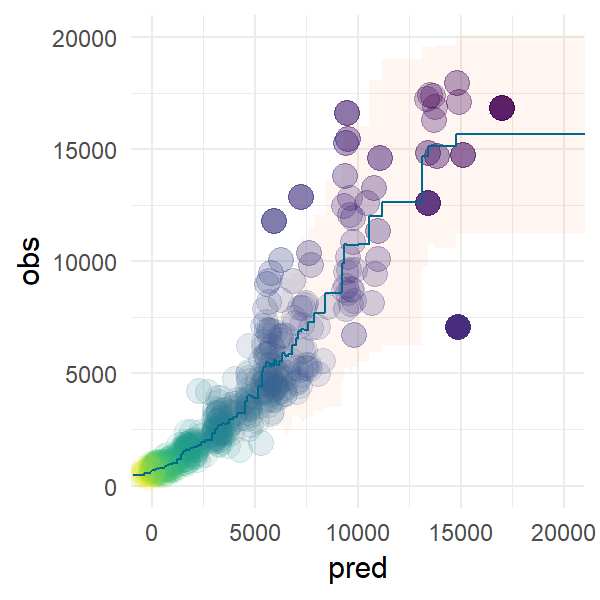

In [48]:
%%R -w 3 -h 3 --units in -r 200
p

# `plotly`
We can convert `ggplot2` plots to `plotly` objects and save them as `html` and embedd them in an iframe.

In [79]:
%%R
require(plotly)
pl = ggplotly(p, tooltip = c('~pred_mean_raw', '~pred_PI2.5_raw', '~pred_PI97.5_raw'))
htmlwidgets::saveWidget(pl, 'pred_intervall.html' )

In [80]:
from IPython.display import IFrame

IFrame("./pred_intervall.html"
      , width = 700
      , height = 700)

# `DT` 
Similarly to `plotly` we can embedd dynamic datatables from the `DT` package

In [55]:
%%R

dt = oetteR::f_datatable_universal( sample_n(df, 500) )
htmlwidgets::saveWidget(dt, 'table.html' )

In [63]:
from IPython.display import IFrame

IFrame("./table.html"
      , width = 1100
      , height = 600)

# `tabplots`
We can use other packages from `R` to integrate other useful visualisations such as `tabplots`

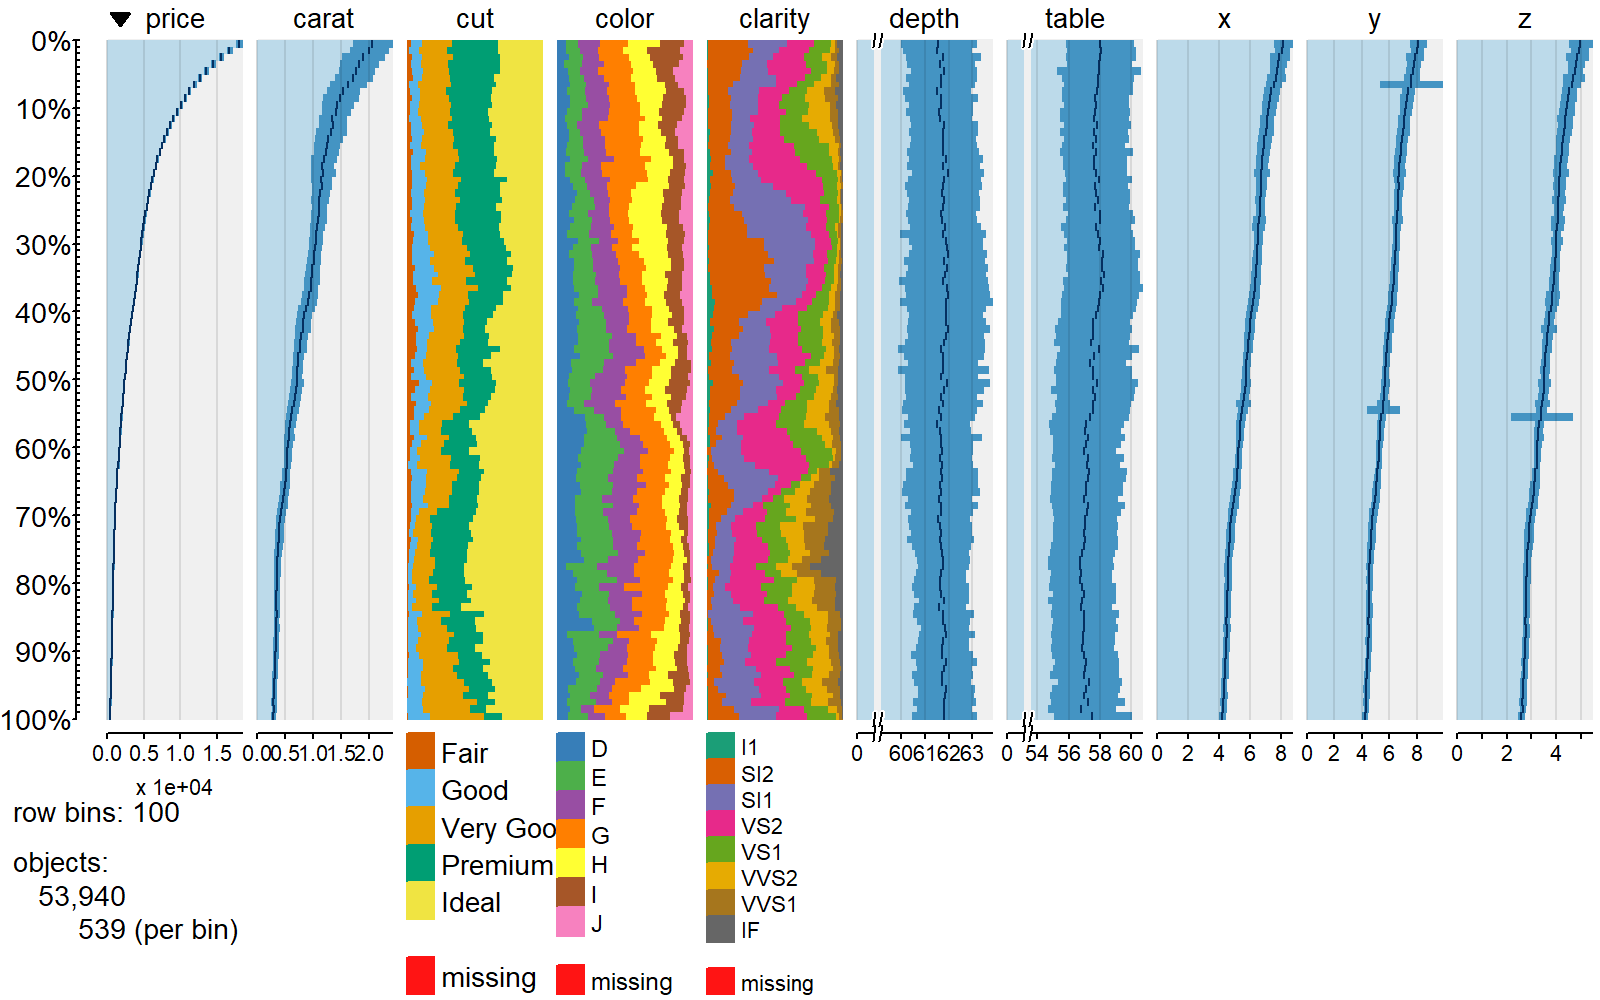

In [71]:
%%R -h 5 -w 8 --units in -r 200

require(tabplot)

tableplot( select(ggplot2::diamonds, price, carat, everything()) )

# `ggalluvial`

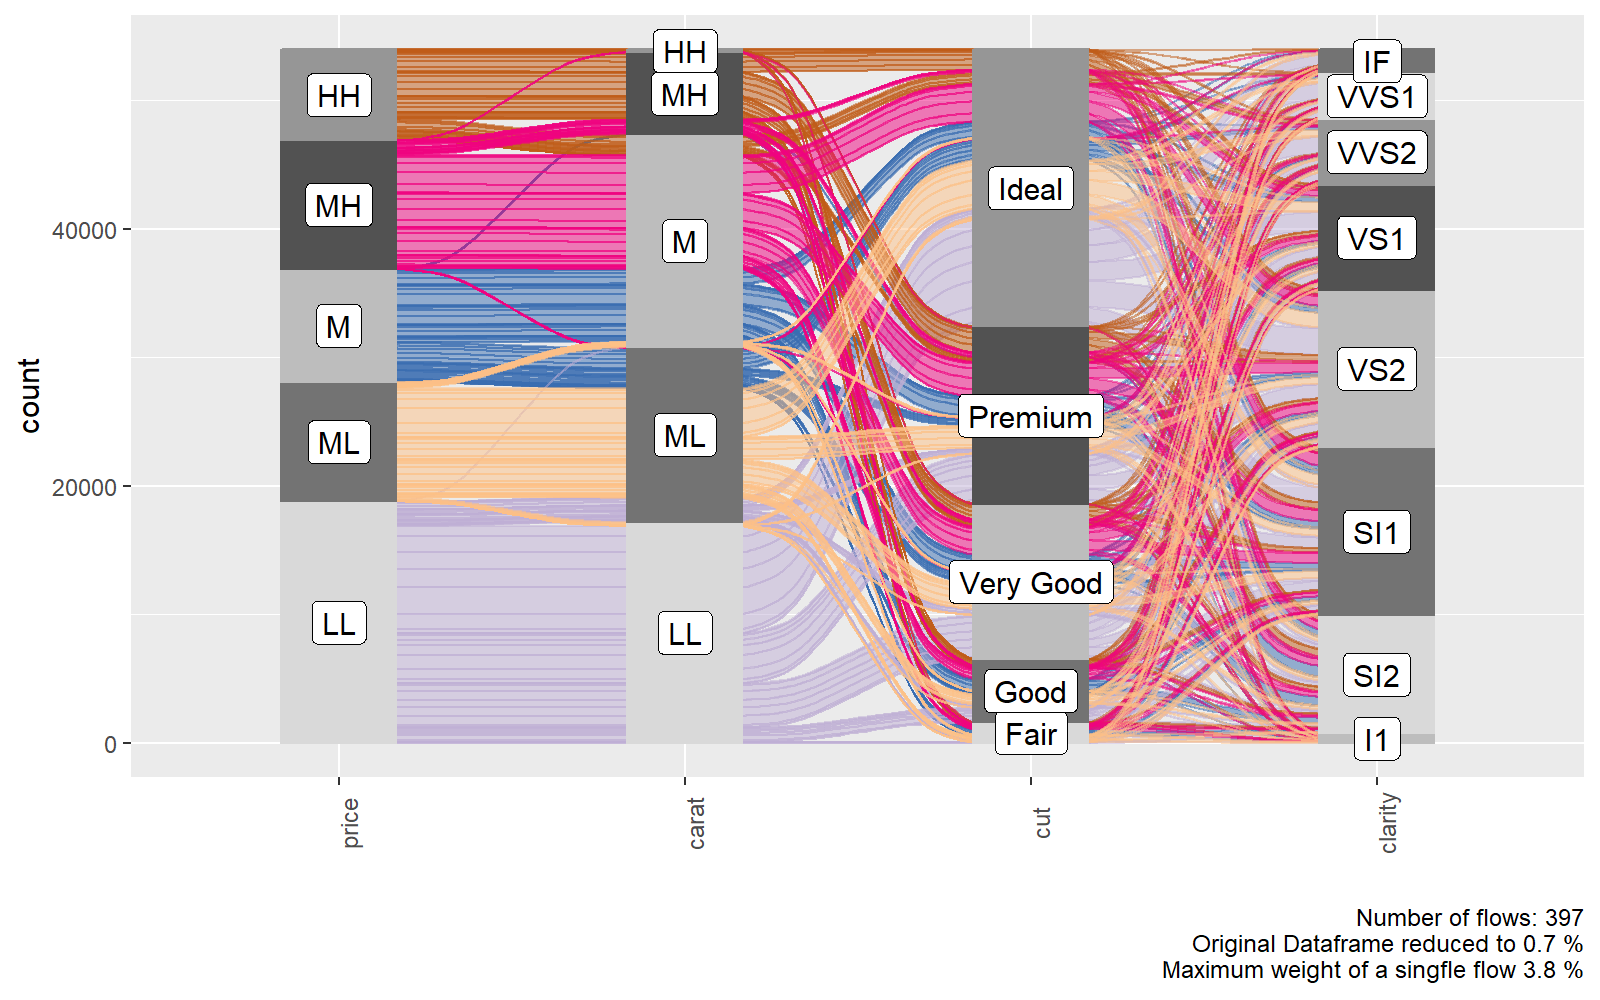

In [78]:
%%R -h 5 -w 8 --units in -r 200

require(oetteR)

f_plot_alluvial( select(ggplot2::diamonds, price, carat, cut, clarity) )

# `ggpubr`

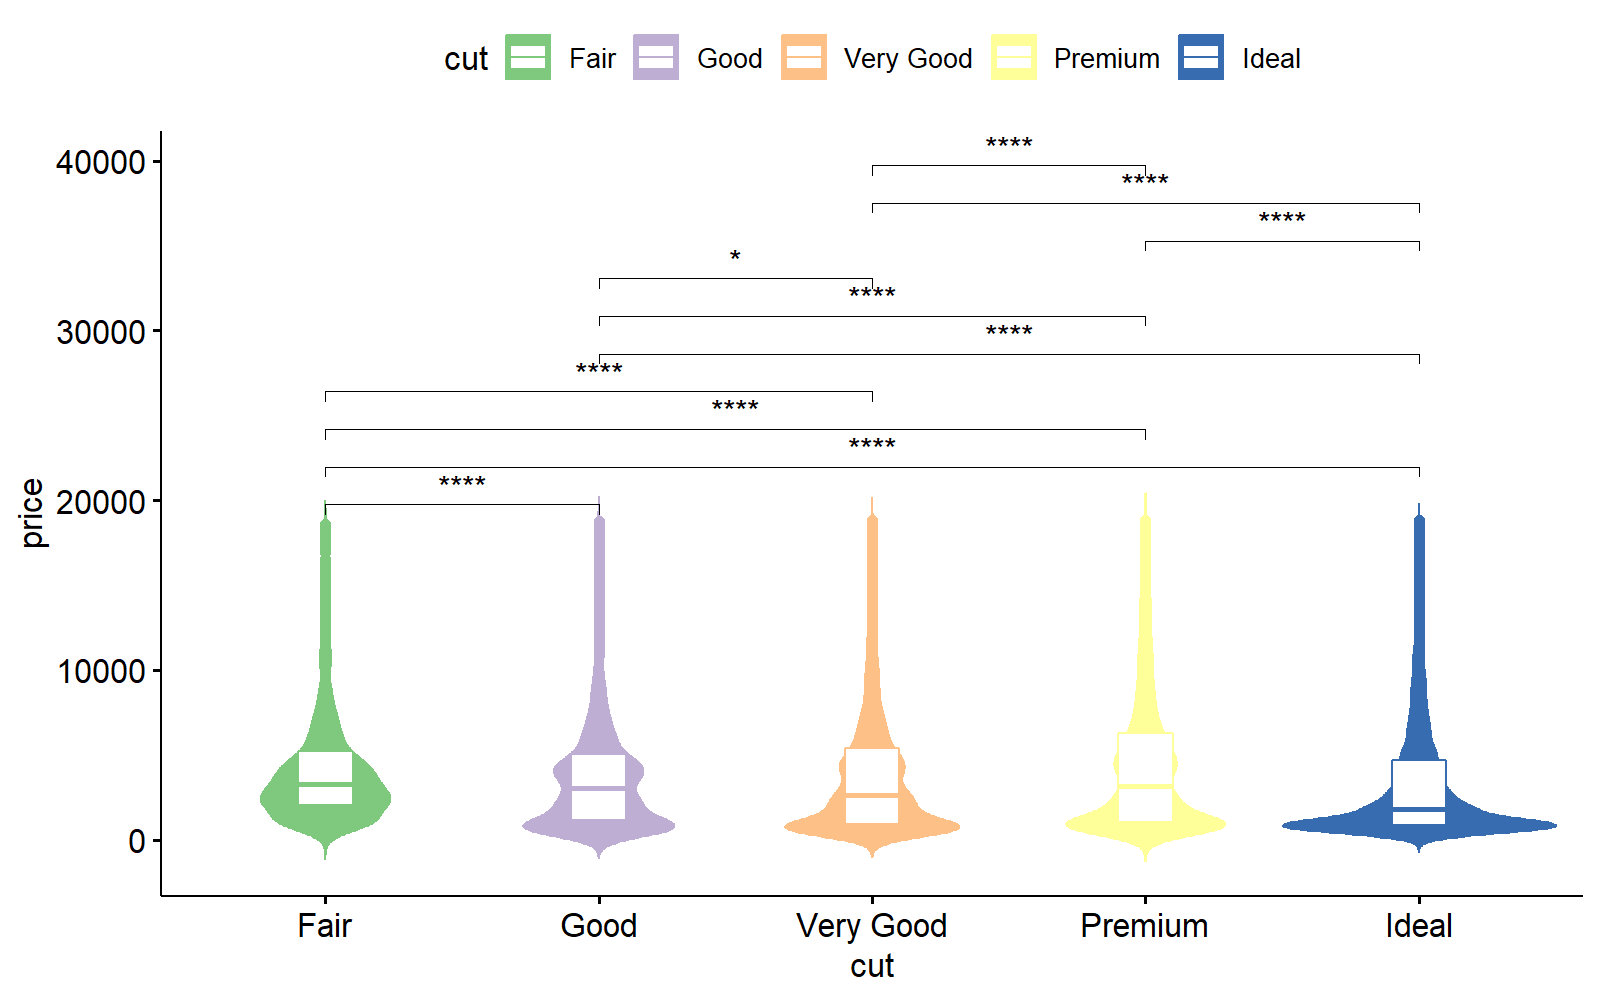

In [91]:
%%R -h 5 -w 8 --units in -r 200

require(ggpubr)
require(oetteR)

# generates all possible compbinations and removes pairings with P val > thresh
compare = f_plot_generate_comparison_pairs(ggplot2::diamonds, 'price', 'cut', thresh = 0.05) 

ggviolin( data = ggplot2::diamonds
           , x = 'cut'
           , y = 'price'
           , color = 'cut'
           , fill = 'cut'
           , palette = f_plot_col_vector74()
           , add = 'boxplot'
           , add.params = list( fill = 'white')
           ) + 
  stat_compare_means(comparisons = compare, label = "p.signif") 